# Orion Conceptual Design

## Introduction
This notebook contains the basic design concept exploration for the orion rocket.
- Rocketpy used for low-fidelity models to sketch out mass constraints for 25km agogee shot
- Use of only existing rocketpy features (solid rocket motor engine *mocking* performance of final liquid)

In [27]:
from typing import Union, Tuple

# Import rocketpy from the rocketpy directory
from importlib.machinery import SourceFileLoader
rocketpy = SourceFileLoader("rocketpy", "../rocketpy/__init__.py").load_module()


# The KSP fork should be used
print(rocketpy.__version__)

0.12.0 fork for KSP


## Environment
The launch environment is not particularly useful here, we use the standard atmosphere, launching from campus.

launch site location:
http://maps.google.com/maps?q=-5.68027,55.433159

Launch Site Details

Launch Rail Length: 4  m
Launch Date: 2022-12-04 12:00:00 UTC
Launch Site Latitude: 55.43316°
Launch Site Longitude: -5.68027°
Reference Datum: SIRGAS2000
Launch Site UTM coordinates: 330421.07 W    6146261.83 N
Launch Site UTM zone: 30U
Launch Site Surface Elevation: 40.0 m


Atmospheric Model Details

Atmospheric Model Type: StandardAtmosphere
StandardAtmosphere Maximum Height: 80.000 km


Surface Atmospheric Conditions

Surface Wind Speed: 0.00 m/s
Surface Wind Direction: 0.00°
Surface Wind Heading: 0.00°
Surface Pressure: 1008.45 hPa
Surface Temperature: 287.89 K
Surface Air Density: 1.220 kg/m³
Surface Speed of Sound: 340.13 m/s


Atmospheric Model Plots


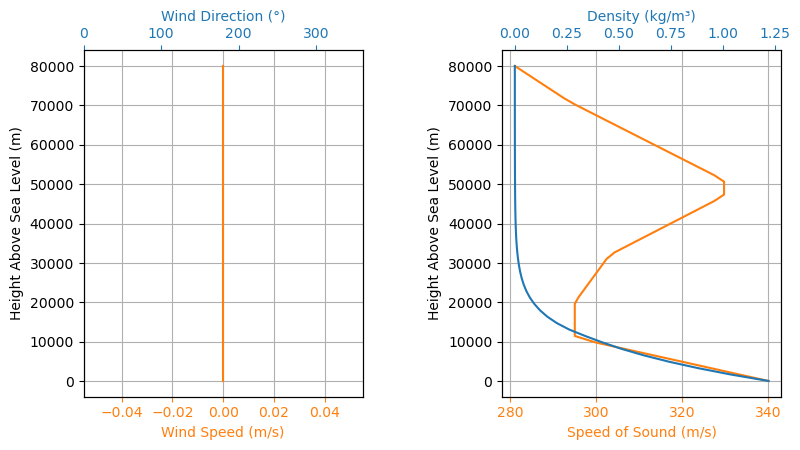

In [28]:
from datetime import date

today = date.today()


LAUNCH_LONGITUDE: float = -5.680270
LAUNCH_LATITUDE: float  = 55.433159

# Coordinates on google maps
print(f"launch site location:\nhttp://maps.google.com/maps?q={LAUNCH_LONGITUDE},{LAUNCH_LATITUDE}\n")


LAUNCH_RAIL_LENGTH: float = 4 

Env = rocketpy.Environment(
    railLength=LAUNCH_RAIL_LENGTH,
    latitude=LAUNCH_LATITUDE,
    longitude=LAUNCH_LONGITUDE,
    elevation=40,
    date=(today.year, today.month, today.day, 12) # Launch today at 12:00
) 

Env.setAtmosphericModel(
    type="StandardAtmosphere"
)

Env.info()

## Constants Table
Used for all the major constants for orion's design

### Nose Cone & Recovery

In [29]:
# GUESS FIGURE - PLEASE CORRECT

# Nose cone type: "Von Karman", "conical", "ogive", "lvhaack"
NOSE_CONE_TYPE: str = "lvhaack"
NOSE_CONE_LENGTH_M: float = 0.435
NOSE_CONE_MASS_KG: float = 0.4

RECOVERY_SECTION_HEIGHT_M: float = 0.1
RECOVERY_SECTION_MASS_KG: float = 0.5

### Avionics Bay

In [30]:
AVIONICS_MASS_KG: float = 1.5
AVIONICS_BAY_HEIGHT_M: float = 0.4

### Tank Section
- 3 main tanks (nitrogen pressuriser, fuel & oxidiser)
- pressure regulator used to keep constant pressure into the fuel/oxidiser tanks

In [31]:
OXIDISER_TANK_HEIGHT_M: float = 1.1
OXIDISER_TANK_MASS_KG: float = 5
OXIDISER_MASS_KG: float = 30

FUEL_TANK_HEIGHT_M: float = 0.5
FUEL_TANK_MASS_KG: float = 2.5
FUEL_MASS_KG: float = 10

NITROGEN_TANK_HEIGHT_M: float = 0.4
NITROGEN_TANK_MASS_KG: float = 2.5
NITROGEN_MASS_KG: float = 8

### Engine Section
This includes the engine plumbing.

In [32]:
ENGINE_AND_PLUMBING_HEIGHT_M: float = 0.5
ENGINE_AND_PLUMBING_MASS_KG: float = 5

### Aerodynamic Stability (Fins)

In [33]:
NO_FINS: int = 4
FINS_MASS_KG: float = 0.648
FIN_ROOT_CHORD_M: float = 0.29
FIN_TIP_CHORD_M: float = 0.080
FIN_SPAN_M: float = 0.100


FINS_CM_M: float = 0.28

### Structures 

In [34]:
ORION_DIAMETER_M: float = 0.2
ORION_SHELL_MASS_KG: float = 23.25
ORION_TAIL_TAPER_DIAMETER_M: float = 0.8 * ORION_DIAMETER_M
ORION_TAIL_LENGTH: float = 0.2

## Rocket Construction
Using the provided constants to create a basic rocketpy rocket:
- Includes any maths on constants to align with rocketpy api (e.g finding component centroids)
- Fins, Nosecone added through methods and have no associated object.

In [35]:

from dataclasses import dataclass


UNLOADED_MASS_KG: float = (
    NOSE_CONE_MASS_KG + 
    RECOVERY_SECTION_MASS_KG + 
    AVIONICS_MASS_KG + 
    OXIDISER_TANK_MASS_KG + 
    FUEL_TANK_MASS_KG +
    NITROGEN_TANK_MASS_KG +
    NITROGEN_MASS_KG +
    ENGINE_AND_PLUMBING_MASS_KG +
    ORION_SHELL_MASS_KG +
    NO_FINS * FINS_MASS_KG
)

LOADED_MASS_KG: float = (
    UNLOADED_MASS_KG +
    FUEL_MASS_KG +
    OXIDISER_MASS_KG
)

@dataclass(frozen=True)
class Component:
    name: str
    position: float
    height: float
    dry_mass: float
    wet_mass_change: float = 0
    center_of_mass: float = position + height / 2

    def component_top(self) -> float:
        return self.position + self.height
        

engine = Component(
    name="Engine and plumming", 
    position=0, 
    height=ENGINE_AND_PLUMBING_HEIGHT_M, 
    dry_mass=ENGINE_AND_PLUMBING_MASS_KG
)

fuel_tank = Component(
    name="Fuel Tank", 
    position=engine.component_top(), 
    height=FUEL_TANK_HEIGHT_M, 
    dry_mass=FUEL_TANK_MASS_KG, 
    wet_mass_change=FUEL_MASS_KG
)

oxidiser_tank = Component(
    name="Oxidiser Tank",
    position=fuel_tank.component_top(),
    height=OXIDISER_TANK_HEIGHT_M,
    dry_mass=OXIDISER_TANK_MASS_KG,
    wet_mass_change=OXIDISER_MASS_KG
)

nitrogen_tank = Component(
    name="Pressurising Tank (Nitrogen)",
    position=oxidiser_tank.component_top(),
    height=NITROGEN_TANK_HEIGHT_M,
    dry_mass=NITROGEN_TANK_MASS_KG + NITROGEN_MASS_KG
)

avionics_bay = Component(
    name="Avionics Bay",
    position=nitrogen_tank.component_top(),
    height=AVIONICS_BAY_HEIGHT_M,
    dry_mass=AVIONICS_MASS_KG
)

recovery_section = Component(
    name="Recovery Section",
    position=avionics_bay.component_top(),
    height=RECOVERY_SECTION_HEIGHT_M,
    dry_mass=RECOVERY_SECTION_MASS_KG
)

nose_cone = Component(
    name="Nosecone",
    position=recovery_section.component_top(),
    height=NOSE_CONE_LENGTH_M,
    dry_mass=NOSE_CONE_MASS_KG
)

orion_shell = Component(
    name="Structre/Shell",
    position=0,
    height=nose_cone.position,
    dry_mass=ORION_SHELL_MASS_KG
)

fins = [Component(
    name=f"Fin {i}",
    position=FIN
) for i in range(NO_FINS)]

rocket_propulsion = [
    engine,
    fuel_tank,
    oxidiser_tank,
    nitrogen_tank
]

rocket_body = rocket_propulsion + [
    avionics_bay,
    recovery_section,
    nose_cone
]

rocket_components = rocket_body + fins + [nose_cone]

# Center of mass calculations
def compute_orion_masses(comps: list[Component]) -> Tuple[float, float, float, float]:
    dry_mass = wet_mass = wet_prod_mass = dry_prod_mass = 0
    for comp in comps:
        dry_mass += comp.dry_mass
        dry_prod_mass += comp.dry_mass * comp.center_of_mass()
        wet_mass += comp.dry_mass + comp.wet_mass_change
        wet_prod_mass += (comp.dry_mass + comp.wet_mass_change) * comp.center_of_mass()
    return dry_mass, wet_mass, dry_prod_mass / dry_mass, wet_prod_mass / wet_mass

orion_propulsion_dry_mass, orion_propulsion_wet_mass, orion_propulsion_dry_cm, orion_propulsion_wet_cm = compute_orion_masses(rocket_propulsion)
orion_dry_mass, orion_wet_mass, orion_dry_cm, orion_wet_cm = compute_orion_masses(rocket_components)

# Inertial I and Z calculations
def compound_inertiaI(rocket_body: list[Component], nose_cone: Component) -> float:
    def cylinder_inertiaI(mass, radius, height) -> float:
        return mass*(3*radius**2 + height**2) / 12

    def cone_inertiaI(mass, radius, height) -> float:
        return 3*mass*(height**2 + 4*radius**2)/80
    
    return (sum([
                cylinder_inertiaI(
                    component.dry_mass, 
                    ORION_DIAMETER_M/2, 
                    component.height
                ) for component in rocket_body]) + 
            cone_inertiaI(
                nose_cone.dry_mass, 
                ORION_DIAMETER_M/2, 
                nose_cone.height
            )
        )

def compound_inertiaZ(rocket_body: list[Component], nose_cone: Component) -> float:
    def cylinder_inertiaZ(mass, radius) -> float:
        return mass*(radius**2)/2

    def cone_inertiaZ(mass, radius) -> float:
        return (3*mass*(radius**2) ) / 10

    return (
        sum([
            cylinder_inertiaZ(
                component.dry_mass, 
                ORION_DIAMETER_M/2
            ) for component in rocket_body]) + 
        cone_inertiaZ(
            nose_cone.dry_mass, 
            ORION_DIAMETER_M/2
        )
    )

inertialI_dry = compound_inertiaI(rocket_body, nose_cone)
inertialZ_dry = compound_inertiaZ(rocket_body, nose_cone)


SyntaxError: invalid syntax (2625928166.py, line 36)

Formulas for computing inertia: I-perpendicular Z-parallel
Nose cone is modelled as a cone, all 

In [36]:
motor = rocketpy.SolidMotor(
    thrustSource="engines/Cesaroni_40960O8000-P.eng",
    burnOut=5.1,
    grainNumber=4, # extreme bodge alert!! Figures pulled out of my ass
    grainDensity=1, # extreme bodge alert!! Figures pulled out of my ass
    grainInitialInnerRadius=0.2 * (ORION_DIAMETER_M/2), # extreme bodge alert!! Figures pulled out of my ass
    grainOuterRadius=0.8 * (ORION_DIAMETER_M/2), # extreme bodge alert!! Figures pulled out of my ass
    grainInitialHeight=1, # extreme bodge alert!! Figures pulled out of my ass
    nozzleRadius=0.8 * (ORION_DIAMETER_M/2),
    throatRadius=0.1 * (ORION_DIAMETER_M/2)
)

## Simulation
Sim of provided rocket with full rocketpy output, and highlighted apogee

Inertia Details
Rocket Mass: 51.242 kg (No Propellant)
Rocket Mass: 51.317 kg (With Propellant)
Rocket Inertia I: 18.382 kg*m2
Rocket Inertia Z: 0.242 kg*m2

Geometrical Parameters
Rocket Maximum Radius: 0.1 m
Rocket Frontal Area: 0.031416 m2

Rocket Distances
Rocket Center of Mass - Nozzle Exit Distance: -1.5162749307208931 m
Rocket Center of Mass - Motor reference point: 0.006551156235628852 m
Rocket Center of Mass - Rocket Loaded Center of Mass: 0.000 m

Aerodynamic Components Parameters
Currently not implemented.

Aerodynamics Lift Coefficient Derivatives
Nose Cone Lift Coefficient Derivative: 2.000/rad
Fins Lift Coefficient Derivative: 2.643/rad
Tail Lift Coefficient Derivative: -0.720/rad

Aerodynamics Center of Pressure
Nose Cone Center of Pressure to CM: 1.946 m
Fins Center of Pressure to CM: -1.273 m
Tail Center of Pressure to CM: 1.613 m
Distance - Center of Pressure to CM: -0.161 m
Initial Static Margin: 0.805 c
Final Static Margin: 0.805 c

Mass Plots


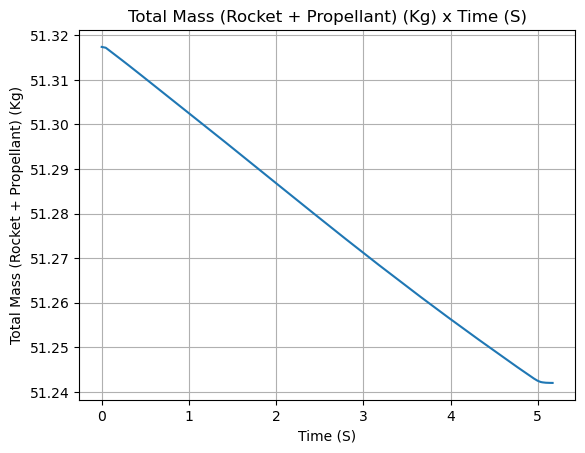

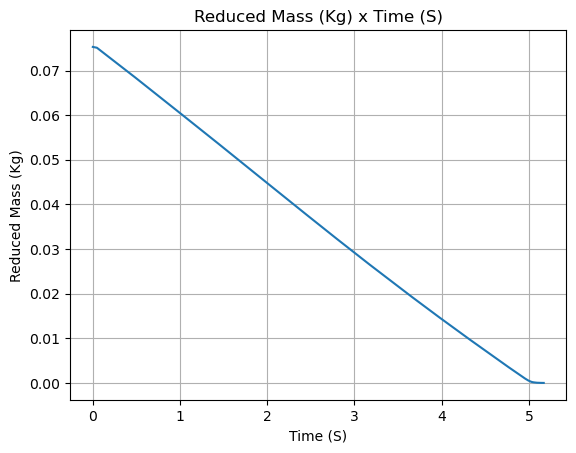


Aerodynamics Plots


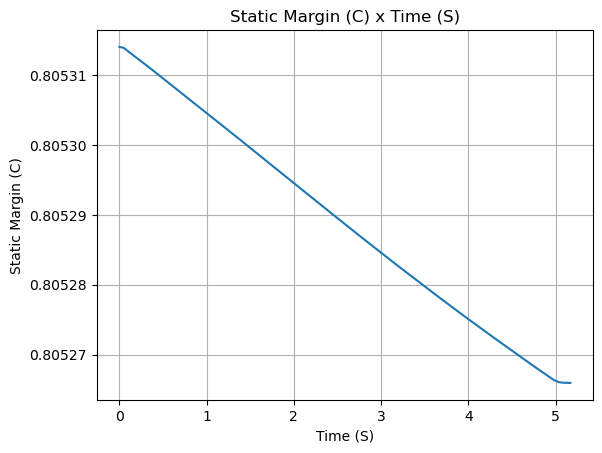

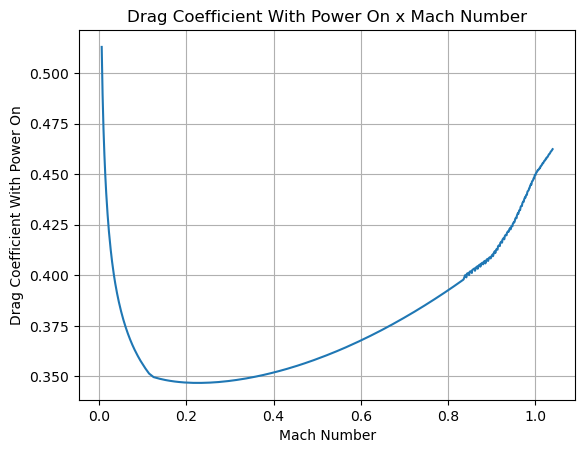

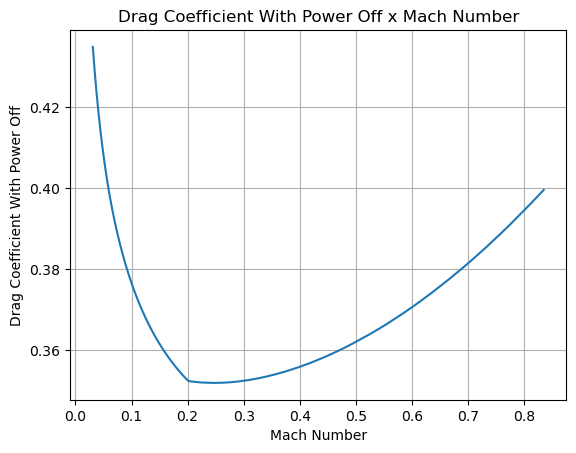

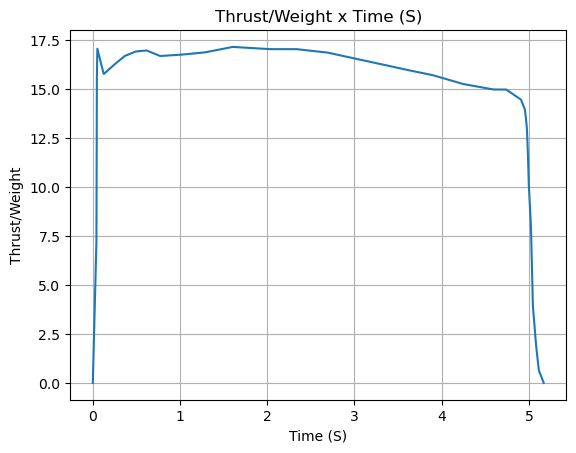

In [38]:
# TODO: Sim code goes here


# TODO: Need to highlight apogee
orion = rocketpy.Rocket(
    motor=motor,
    mass=orion_dry_mass,
    inertiaI=inertialI_dry,
    inertiaZ=inertialZ_dry,
    radius=ORION_DIAMETER_M / 2,
    distanceRocketNozzle=-orion_dry_cm,
    distanceRocketPropellant=orion_propulsion_dry_cm-orion_dry_cm,
    powerOffDrag="drag_curves/powerOffDragCurve.csv",
    powerOnDrag="drag_curves/powerOnDragCurve.csv"
)

orion.setRailButtons([0.2, -0.5]) # (PLEASE UPDATE) rail button positions (relatiuve to center of mass)
orion.addNose(length=NOSE_CONE_LENGTH_M, kind=NOSE_CONE_TYPE, distanceToCM=nose_cone.center_of_mass() - orion_dry_cm)
orion.addTrapezoidalFins(NO_FINS, FIN_ROOT_CHORD_M, FIN_TIP_CHORD_M, FIN_SPAN_M, fins[0].center_of_mass() - orion_dry_cm)
orion.addTail(ORION_DIAMETER_M / 2, ORION_TAIL_TAPER_DIAMETER_M / 2, ORION_TAIL_LENGTH, orion_dry_cm)

orion.allInfo()

Initial Conditions

Position - x: 0.00 m | y: 0.00 m | z: 40.00 m
Velocity - Vx: 0.00 m/s | Vy: 0.00 m/s | Vz: 0.00 m/s
Attitude - e0: 0.999 | e1: -0.044 | e2: -0.000 | e3: 0.000
Euler Angles - Spin φ : 0.00° | Nutation θ: -5.00° | Precession ψ: 0.00°
Angular Velocity - ω1: 0.00 rad/s | ω2: 0.00 rad/s| ω3: 0.00 rad/s


Launch Rail Orientation

Launch Rail Inclination: 85.00°
Launch Rail Heading: 0.00°


Surface Wind Conditions

Frontal Surface Wind Speed: 0.00 m/s
Lateral Surface Wind Speed: 0.00 m/s


 Rail Departure State

Rail Departure Time: 0.210 s
Rail Departure Velocity: 25.879 m/s
Rail Departure Static Margin: 0.805 c
Rail Departure Angle of Attack: 0.000°
Rail Departure Thrust-Weight Ratio: 16.101
Rail Departure Reynolds Number: 3.532e+05


BurnOut State

BurnOut time: 5.170 s
Altitude at burnOut: 1827.805 m (AGL)
Rocket velocity at burnOut: 619.402 m/s
Freestream velocity at burnOut: 619.402 m/s
Mach Number at burnOut: 1.862
Kinetic energy at burnOut: 9.830e+06 J


Apogee

Ap

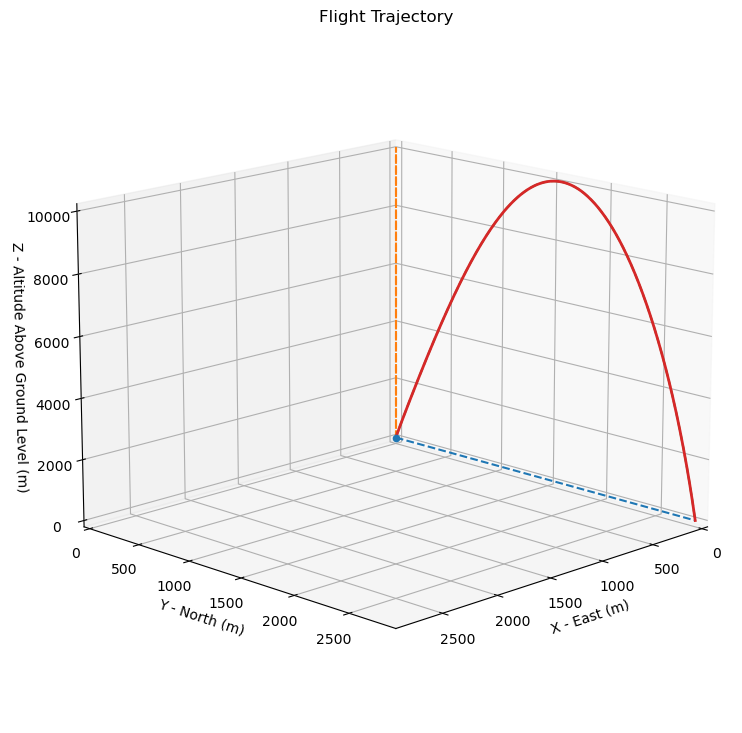



Trajectory Kinematic Plots



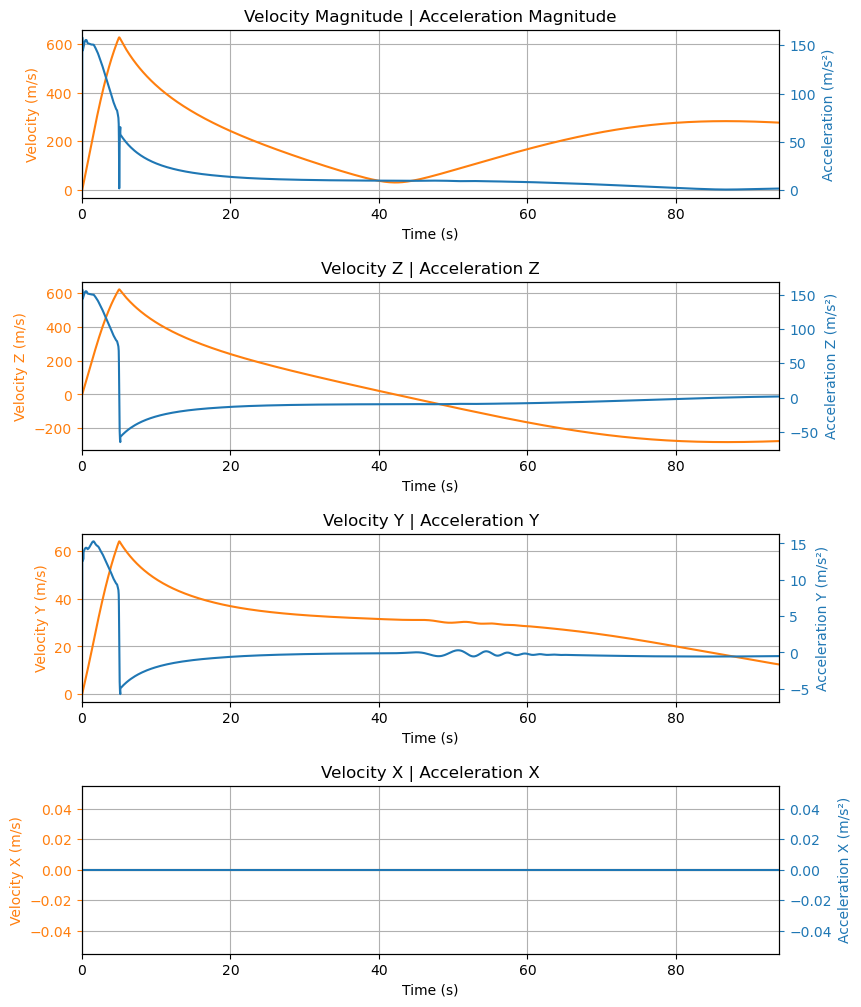



Angular Position Plots



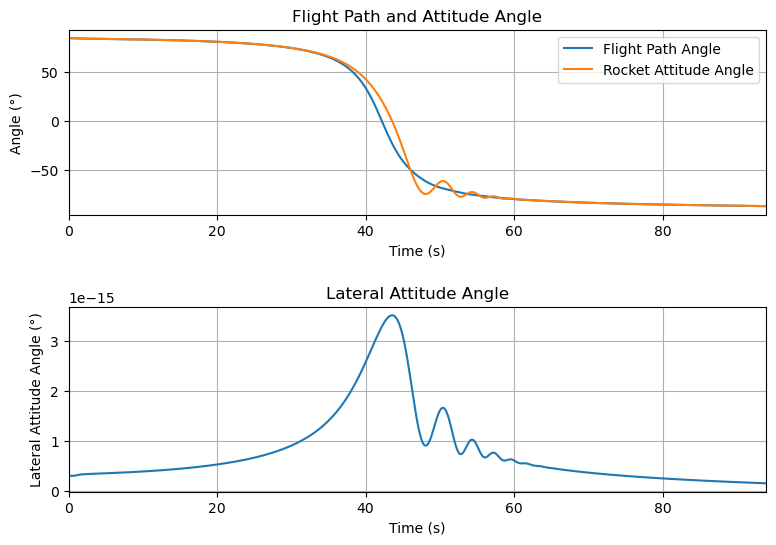



Path, Attitude and Lateral Attitude Angle plots



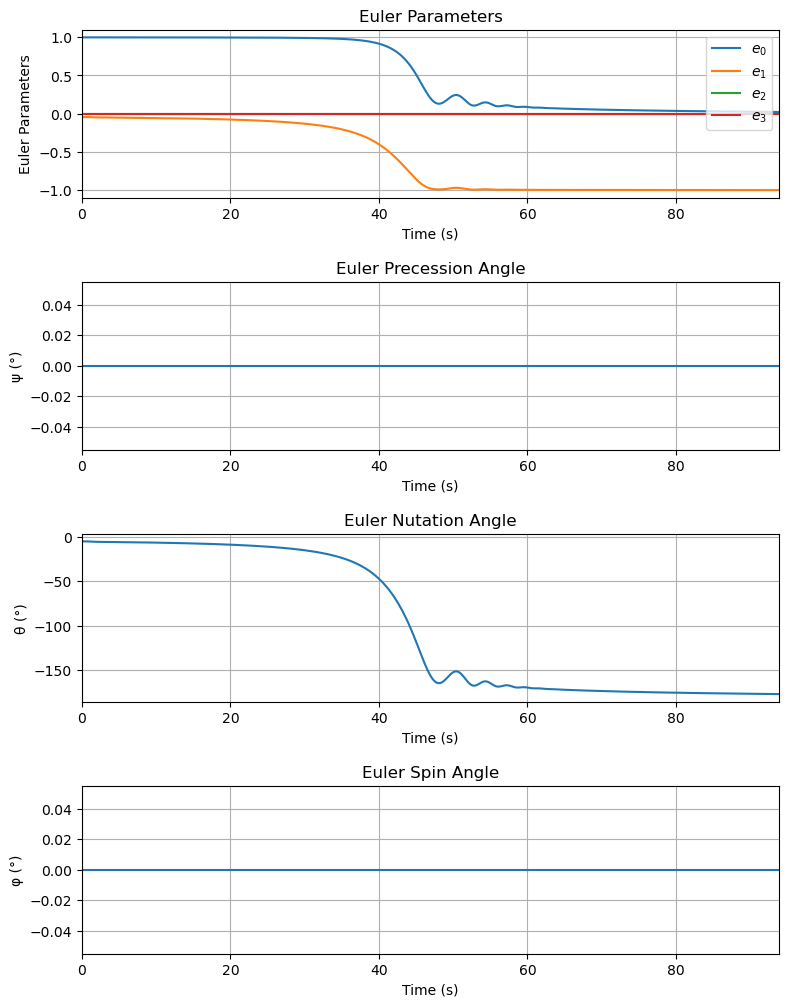



Trajectory Angular Velocity and Acceleration Plots



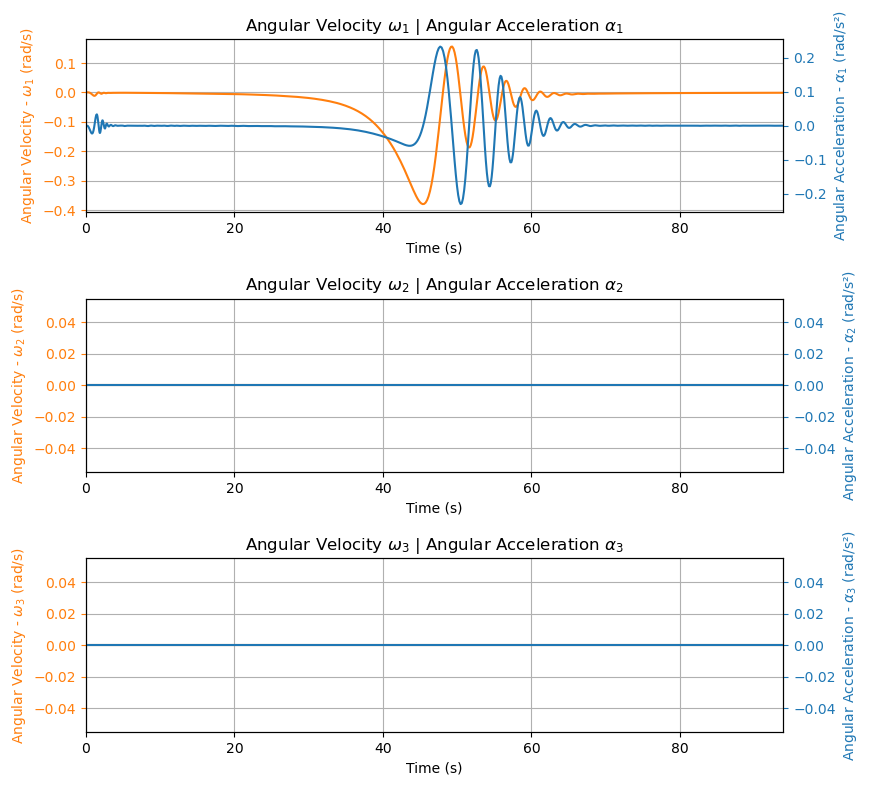



Trajectory Force Plots



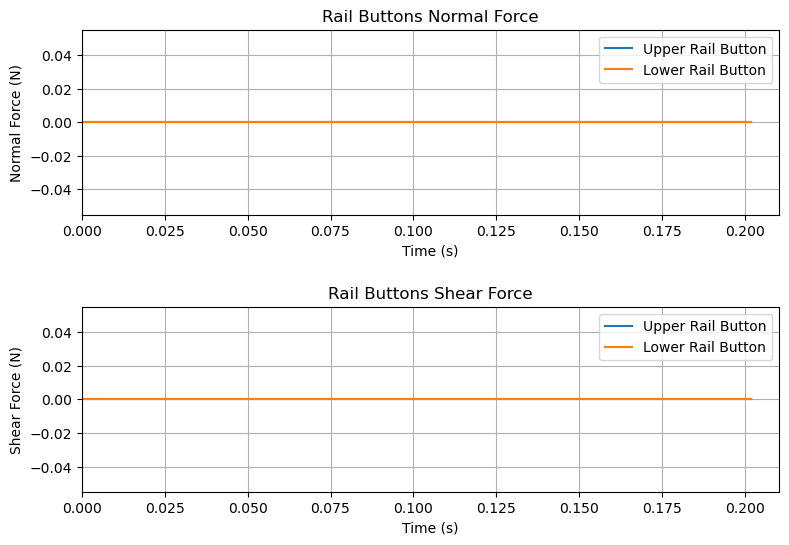

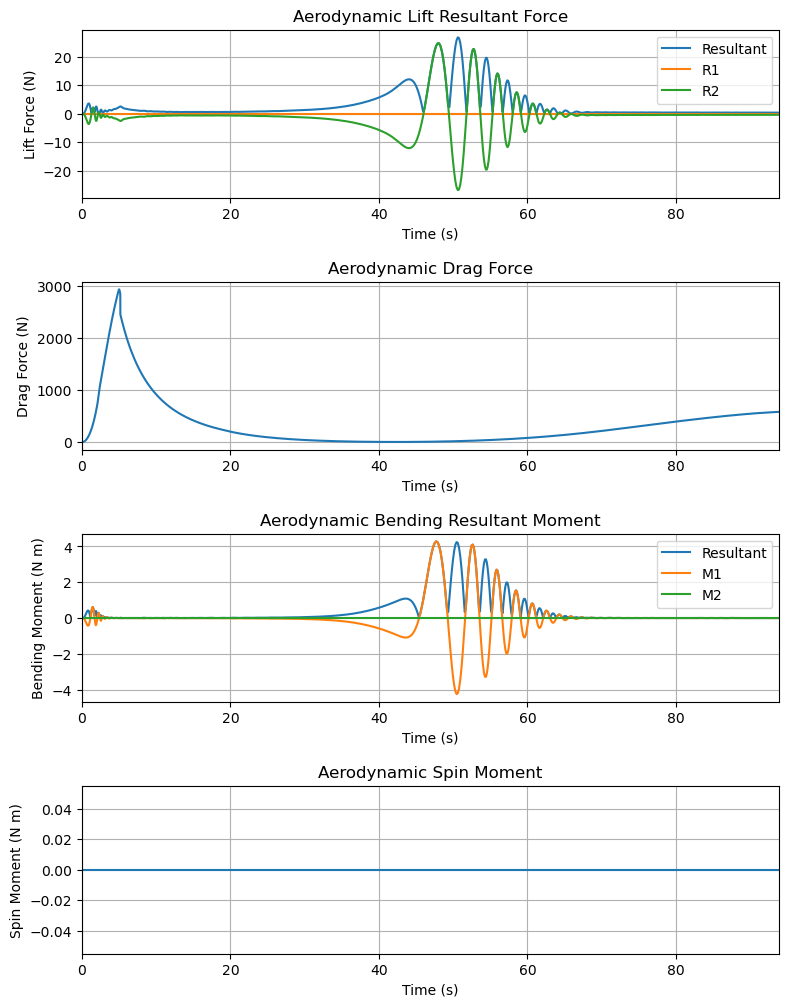



Trajectory Energy Plots



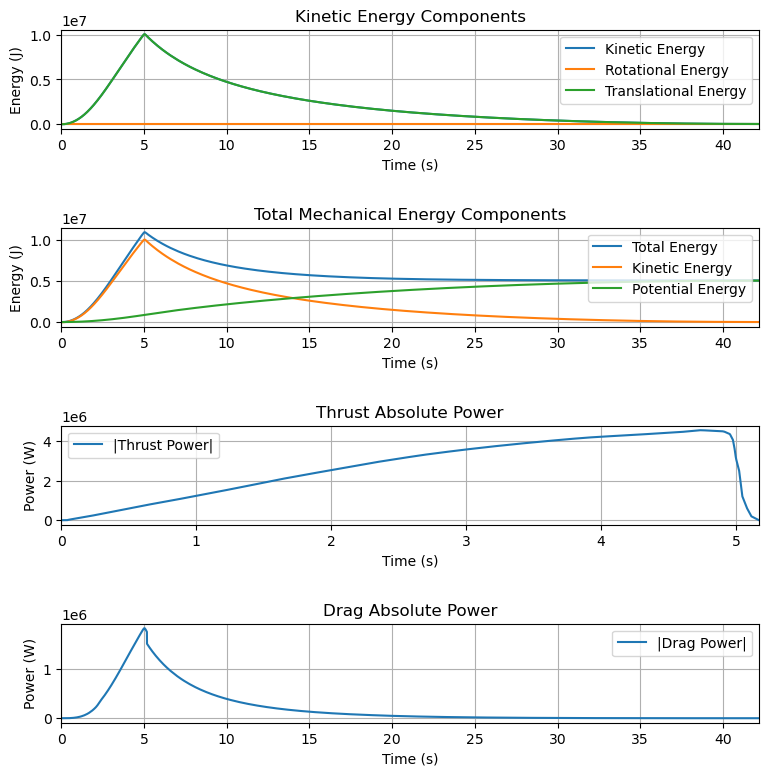



Trajectory Fluid Mechanics Plots



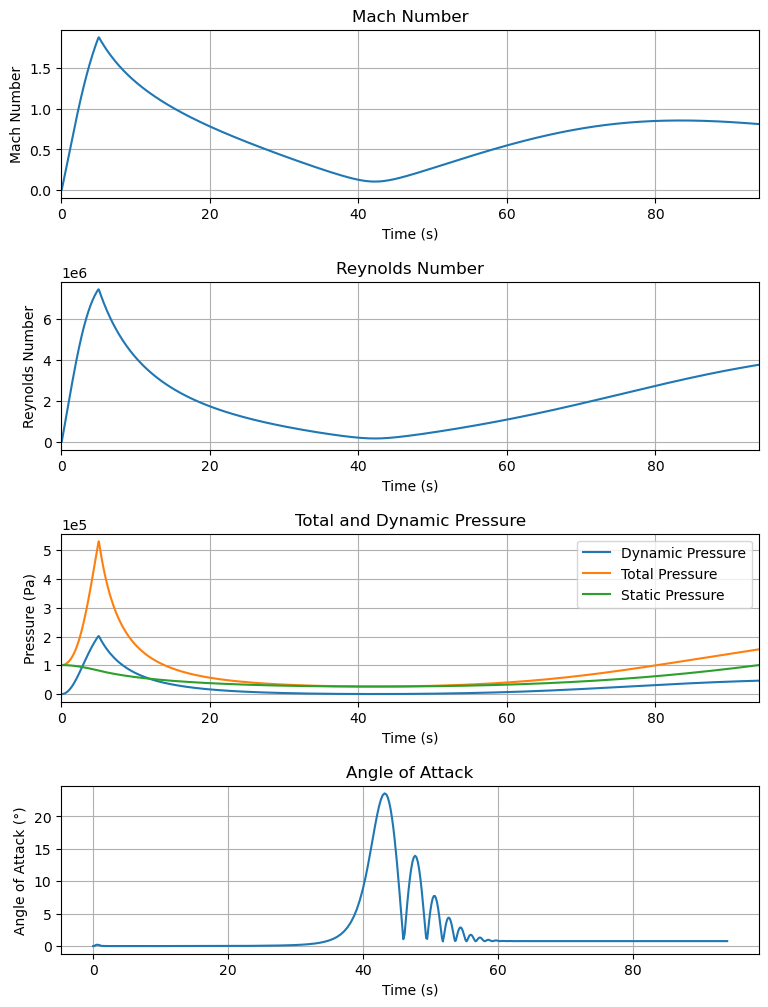



Trajectory Stability and Control Plots



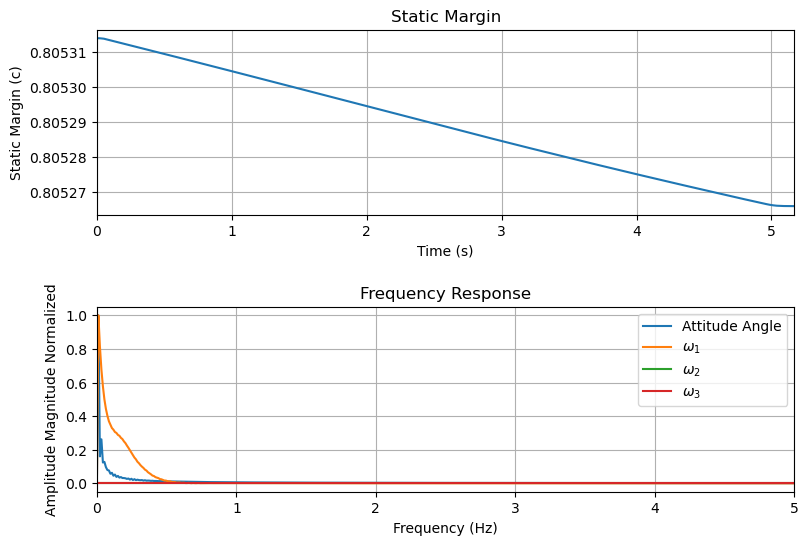

In [39]:
TestFlight = rocketpy.Flight(rocket=orion, environment=Env, inclination=85, heading=0)
TestFlight.allInfo()